In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gmm_exp' in c['name'] 
        and c['config']['dataset']['n_sets'] == 10000
        and c['config']['experiment']['latent_dim'] == 32
        and c['config']['experiment']['hidden_dim'] == 128
        and c['config']['dataset']['prior_mu'] == [0, 5]
        and c['config']['dataset']['set_size'] == 500
]

In [3]:
import hydra
# load + prep dataset
def prepare_dataset_and_mixer(cfg, set_size=None, n_sets=None, n_mixed_sets=None):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    if set_size is not None:
        cfg['dataset']['set_size'] = set_size
    if n_sets is not None:
        cfg['dataset']['n_sets'] = n_sets
    if n_mixed_sets is not None:
        cfg['mixer']['n_mixed_sets'] = n_mixed_sets
    dataset = hydra.utils.instantiate(cfg['dataset'])
    mixer = hydra.utils.instantiate(cfg['mixer'])
    return dataset, mixer


# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [4]:
from torch.utils.data import DataLoader
ds, mx = prepare_dataset_and_mixer(cfgs[0]['config'], set_size=1_000_000, n_sets=100, n_mixed_sets=1)
dl = DataLoader(ds, batch_size=3, shuffle=False, collate_fn=mx.collate_fn)

In [98]:
dl_iter = iter(dl)
gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

In [30]:
# clear cuda cahce and gc
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [6]:
import numpy as np
import torch
samples_s = gmm_s['samples'].squeeze()
samples_t = gmm_t['samples'].squeeze()
lat = enc(torch.from_numpy(np.concatenate([samples_s[None, :20_000, :], samples_t[None, :20_000, :]], axis=0)).float().to(device))
# resample = gen.sample(lat, 1_000_000, return_trajectory=False)
# linearly interpolate between the two points
lat_interp = lat[0] + (lat[1] - lat[0]) * torch.linspace(0, 1, 10)[:, None].to(device)
resample = gen.sample(lat_interp, 1_000_000, return_trajectory=False)


Text(0.5, 1.0, 'Resampled Distribution')

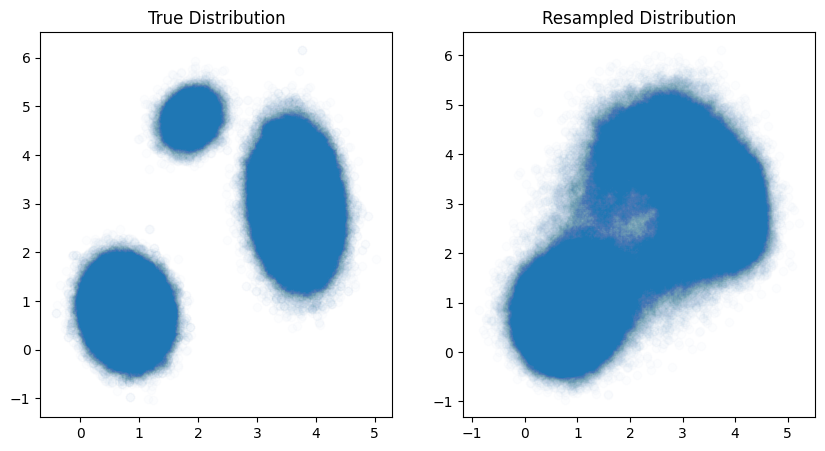

In [32]:
from matplotlib import pyplot as plt

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(samples_s[:, 0], samples_s[:, 1], label='True $s$', alpha=0.01)
axs[1].scatter(resample[0, :, 0].cpu().numpy(), resample[0, :, 1].cpu().numpy(), label='Resampled $s$', alpha=0.01)
axs[0].set_title('True Distribution')
axs[1].set_title('Resampled Distribution')



In [10]:
gmm_t['mean'].shape

torch.Size([3, 2])

In [199]:
import numpy as np
from sklearn.mixture import GaussianMixture
from typing import Tuple, List
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors
import torch
import torch.autograd.functional as F
from ot.utils import proj_SDP
from ot.gmm import gmm_ot_loss

def fit_gmm_batch(samples: np.ndarray,
                 init_means: np.ndarray,
                 init_covs: np.ndarray,
                 init_weights: np.ndarray,
                 n_iter: int = 100,
                 tol: float = 1e-6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit multiple GMMs to batches of samples using sklearn's GaussianMixture.
    
    Args:
        samples: Array of shape (num_mixtures, num_samples, dim) containing the data points
        init_means: Initial means of shape (num_mixtures, n_components, dim)
        init_covs: Initial covariance matrices of shape (num_mixtures, n_components, dim, dim)
        init_weights: Initial mixing weights of shape (num_mixtures, n_components)
        n_iter: Maximum number of EM iterations
        tol: Convergence tolerance for log-likelihood
        
    Returns:
        means: Final means of shape (num_mixtures, n_components, dim)
        covs: Final covariance matrices of shape (num_mixtures, n_components, dim, dim)
        weights: Final mixing weights of shape (num_mixtures, n_components)
    """
    num_mixtures, num_samples, dim = samples.shape
    n_components = init_means.shape[1]
    
    # Initialize output arrays
    means = np.zeros_like(init_means)
    covs = np.zeros_like(init_covs)
    weights = np.zeros_like(init_weights)
    
    # Fit GMM for each mixture independently
    for mix_idx in range(num_mixtures):
        # Initialize GMM with given parameters
        # double cast weights to normalize
        weights_init_double = init_weights[mix_idx].astype(np.float64)
        weights_init_double = weights_init_double / np.sum(weights_init_double)
        gmm = GaussianMixture(
            n_components=n_components,
            max_iter=n_iter,
            tol=tol,
            covariance_type='full',
            weights_init=weights_init_double,
            means_init=init_means[mix_idx],
            precisions_init=np.linalg.inv(init_covs[mix_idx]),
            warm_start=True,
            random_state=None
        )
        
        # Fit the model
        gmm.fit(samples[mix_idx])
        
        # Store results
        means[mix_idx] = gmm.means_
        covs[mix_idx] = gmm.covariances_
        weights[mix_idx] = gmm.weights_
        print("Fit GMM for mixture", mix_idx)
    
    return means, covs, weights 

def plot_gmm_trajectory(means: np.ndarray, 
                       covs: np.ndarray, 
                       weights: np.ndarray,
                       figsize: Tuple[int, int] = (15, 6),
                       alpha: float = 0.3,
                       n_std: float = 2,
                       title: str = None) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot the trajectory of Gaussian components over time with a separate simplex plot for weights.
    
    Args:
        means: Array of shape (num_timesteps, n_components, dim)
        covs: Array of shape (num_timesteps, n_components, dim, dim)
        weights: Array of shape (num_timesteps, n_components)
        figsize: Figure size (width, height) for the combined plot
        alpha: Transparency of ellipses
        n_std: Number of standard deviations for ellipse size
        title: Optional title for the trajectory plot
    
    Returns:
        fig: Figure object containing both plots
        (ax_traj, ax_weights): Tuple of Axes objects for trajectory and weights
    """
    if means.shape[-1] != 2:
        raise ValueError("This visualization only works for 2D Gaussian mixtures")
        
    num_timesteps, n_components, _ = means.shape
    
    # Create figure with two subplots
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(1, 2, width_ratios=[2, 1])
    ax_traj = fig.add_subplot(gs[0])
    ax_weights = fig.add_subplot(gs[1])
    
    # Set up colors for components
    component_colors = plt.cm.Set2(np.linspace(0, 1, n_components))
    time_colors = plt.cm.viridis(np.linspace(0, 1, num_timesteps))
    
    # Plot trajectories and ellipses
    for k in range(n_components):
        trajectory = means[:, k]
        
        # Plot mean trajectory
        ax_traj.plot(trajectory[:, 0], trajectory[:, 1], '--', 
                    color=component_colors[k], alpha=0.5,
                    label=f'Component {k}')
        
        # Plot ellipses and means at each timestep
        for t in range(num_timesteps):
            # Calculate eigenvalues and eigenvectors
            eigenvals, eigenvecs = np.linalg.eigh(covs[t, k])
            
            # Calculate angle and axes lengths for ellipse
            angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
            width, height = 2 * n_std * np.sqrt(eigenvals)
            
            # Create and add ellipse
            ellipse = Ellipse(xy=means[t, k],
                            width=width,
                            height=height,
                            angle=angle,
                            facecolor=time_colors[t],
                            alpha=alpha,
                            edgecolor=component_colors[k],
                            linewidth=1)
            ax_traj.add_patch(ellipse)
            
            # Plot mean point
            ax_traj.plot(means[t, k, 0], means[t, k, 1], 'o',
                        color=component_colors[k], markersize=4)
    
    # Configure trajectory plot
    ax_traj.set_aspect('equal')
    ax_traj.grid(True, alpha=0.3)
    ax_traj.set_xlabel('x')
    ax_traj.set_ylabel('y')
    if title:
        ax_traj.set_title(title)
    ax_traj.legend()
    
    # Add colorbar to show time progression
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                              norm=plt.Normalize(vmin=0, vmax=num_timesteps-1))
    plt.colorbar(sm, ax=ax_traj, label='Time step')
    
    # Plot weights evolution in probability simplex
    plot_weight_simplex(weights, ax_weights, component_colors)
    
    plt.tight_layout()
    return fig, (ax_traj, ax_weights)

def plot_weight_simplex(weights: np.ndarray, 
                       ax: plt.Axes, 
                       colors: np.ndarray) -> None:
    """
    Plot the evolution of mixture weights in a probability simplex.
    
    Args:
        weights: Array of shape (num_timesteps, n_components)
        ax: Matplotlib axes to plot on
        colors: Array of colors for each component
    """
    num_timesteps, n_components = weights.shape
    
    if n_components == 2:
        # For 2 components, plot as a 1D line
        times = np.arange(num_timesteps)
        ax.plot(times, weights[:, 0], '-o', color=colors[0], label='Component 0',
               markersize=4, markeredgecolor='white', markeredgewidth=1)
        ax.plot(times, weights[:, 1], '-o', color=colors[1], label='Component 1',
               markersize=4, markeredgecolor='white', markeredgewidth=1)
        ax.set_xlabel('Time step')
        ax.set_ylabel('Weight')
        ax.grid(True, alpha=0.3)
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.set_title('Weight Evolution')
        
    elif n_components == 3:
        # For 3 components, plot in triangular simplex
        # Convert to barycentric coordinates
        triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(0.75)]])
        barycentric = weights @ triangle
        
        # Draw the simplex triangle
        ax.plot([0, 1], [0, 0], 'k-', alpha=0.3, linewidth=1)
        ax.plot([0, 0.5], [0, np.sqrt(0.75)], 'k-', alpha=0.3, linewidth=1)
        ax.plot([1, 0.5], [0, np.sqrt(0.75)], 'k-', alpha=0.3, linewidth=1)
        
        # Add grid lines inside the simplex
        n_lines = 6  # number of grid lines per edge
        
        for i in range(1, n_lines):
            t = i / n_lines
            
            # Lines parallel to bottom edge
            start = np.array([0, 0]) * (1-t) + np.array([0.5, np.sqrt(0.75)]) * t
            end = np.array([1, 0]) * (1-t) + np.array([0.5, np.sqrt(0.75)]) * t
            ax.plot([start[0], end[0]], [start[1], end[1]], 'gray', alpha=0.2, linewidth=0.5)
            
            # Lines parallel to left edge
            start = np.array([0, 0]) * (1-t) + np.array([1, 0]) * t
            end = np.array([0.5, np.sqrt(0.75)]) - (np.array([0.5, np.sqrt(0.75)]) - np.array([0, 0])) * (1-t)
            ax.plot([start[0], end[0]], [start[1], end[1]], 'gray', alpha=0.2, linewidth=0.5)
            
            # Lines parallel to right edge
            start = np.array([1, 0]) * (1-t) + np.array([0.5, np.sqrt(0.75)]) * t
            end = np.array([0, 0]) + (np.array([1, 0]) - np.array([0, 0])) * (1-t)
            ax.plot([start[0], end[0]], [start[1], end[1]], 'gray', alpha=0.2, linewidth=0.5)
        
        # Plot trajectory with gradient color
        points = barycentric.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        time_colors = plt.cm.viridis(np.linspace(0, 1, num_timesteps-1))
        
        # Plot trajectory line
        for i, (p1, p2) in enumerate(segments):
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], '-',
                   color=time_colors[i], linewidth=2, alpha=0.7)
        
        # Plot points with white edge for better visibility
        for t in range(num_timesteps):
            color = plt.cm.viridis(t / (num_timesteps-1))
            ax.plot(barycentric[t, 0], barycentric[t, 1], 'o',
                   color=color, markersize=6,
                   markeredgecolor='white', markeredgewidth=1)
        
        # Add component labels with better positioning
        label_pad = 0.05
        ax.text(0, -label_pad, 'Component 0', ha='center', va='top')
        ax.text(1, -label_pad, 'Component 1', ha='center', va='top')
        ax.text(0.5, np.sqrt(0.75)+label_pad, 'Component 2', ha='center', va='bottom')
        
        # Add small dots at vertices with component colors
        vertex_size = 80
        ax.scatter([0, 1, 0.5], [0, 0, np.sqrt(0.75)], 
                  c=colors[:3], s=vertex_size, zorder=10,
                  edgecolor='white', linewidth=1.5)
        
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Add title with adjusted position
        ax.set_title('Weight Simplex Trajectory', pad=20)
        
        # Set limits with padding
        pad = 0.1
        ax.set_xlim(-pad, 1+pad)
        ax.set_ylim(-pad, np.sqrt(0.75)+pad)
        
    else:
        # For >3 components, show weight evolution over time
        times = np.arange(num_timesteps)
        for k in range(n_components):
            ax.plot(times, weights[:, k], '-o', 
                   color=colors[k], label=f'Component {k}',
                   markersize=4, markeredgecolor='white', markeredgewidth=1)
        ax.set_xlabel('Time step')
        ax.set_ylabel('Weight')
        ax.grid(True, alpha=0.3)
        ax.legend(frameon=True, fancybox=True, shadow=True)
        ax.set_title('Weight Evolution') 

def optimize_gmm(m_s: torch.Tensor,
                m_t: torch.Tensor,
                C_s: torch.Tensor,
                C_t: torch.Tensor,
                w_s: torch.Tensor,
                w_t: torch.Tensor,
                n_steps: int = 100,
                lr: float = 0.01,
                min_cov: float = 1e-6,
                use_natural_gradient: bool = False,
                damping: float = 1e-4) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[float]]:
    """
    Optimize GMM parameters using torch's functional autograd API with optional natural gradient.
    
    Args:
        m_s: Source means tensor
        m_t: Target means tensor
        C_s: Source covariance tensor
        C_t: Target covariance tensor
        w_s: Source weights tensor (logits)
        w_t: Target weights tensor
        n_steps: Number of optimization steps
        lr: Learning rate
        min_cov: Minimum eigenvalue for covariance matrices
        use_natural_gradient: Whether to use natural gradient descent
        damping: Damping factor for Hessian inversion
    
    Returns:
        means_list: List of mean arrays through optimization
        covs_list: List of covariance arrays through optimization
        weights_list: List of weight arrays through optimization
        loss_list: List of loss values through optimization
    """
    # Ensure inputs are on CPU and detached
    m_t, C_t, w_t = map(lambda x: x.detach().cpu().requires_grad_(False), (m_t, C_t, w_t))
    
    # Initialize parameters
    means = m_s.clone().detach().requires_grad_(True)
    covs = C_s.clone().detach().requires_grad_(True)
    logits = w_s.clone().detach().requires_grad_(True)
    params = (means, covs, logits)
    shapes = [p.shape for p in params]
    
    def flatten_params(params):
        flat = torch.cat([p.reshape(-1) for p in params])
        flat.requires_grad_(True)
        return flat
    
    def unflatten_params(flat_params):
        result = []
        idx = 0
        for shape in shapes:
            n_params = np.prod(shape)
            param = flat_params[idx:idx + n_params].reshape(shape)
            param.requires_grad_(True)
            result.append(param)
            idx += n_params
        return tuple(result)
    
    def loss_fn(params_flat):
        """Loss function that takes flattened parameters."""
        means, covs, logits = unflatten_params(params_flat)
        weights = torch.softmax(logits, dim=0)
        covs = proj_SDP(covs)
        return gmm_ot_loss(means, m_t, covs, C_t, weights, w_t)
    
    # Initialize trajectory storage
    means_list = [means.detach().cpu().numpy()]
    covs_list = [covs.detach().cpu().numpy()]
    weights_list = [torch.softmax(logits, dim=0).detach().cpu().numpy()]
    loss_list = []
    
    params_flat = flatten_params(params)
    
    for _ in range(n_steps):
        # Compute loss and gradients
        loss = loss_fn(params_flat)
        grad_flat = torch.autograd.grad(loss, params_flat, create_graph=True)[0]
        
        if use_natural_gradient:
            # Compute Hessian directly
            H = torch.autograd.functional.hessian(loss_fn, params_flat)
            
            # Add damping and solve for natural gradient
            H_damped = H + damping * torch.eye(H.shape[0], dtype=H.dtype)
            nat_grad_flat = torch.linalg.solve(H_damped, grad_flat)
            
            grad_flat = nat_grad_flat
        
        # Update parameters
        with torch.no_grad():
            params_flat = params_flat - lr * grad_flat
            params_flat.requires_grad_(True)
            params = unflatten_params(params_flat)
            means, covs, logits = params
            
        # Store current state
        means_list.append(means.detach().cpu().numpy())
        covs_list.append(proj_SDP(covs).clone().detach().cpu().numpy())
        weights_list.append(torch.softmax(logits, dim=0).detach().cpu().numpy())
        loss_list.append(loss.item())
    
    return np.array(means_list), np.array(covs_list), np.array(weights_list), np.array(loss_list) 

In [200]:
# from gmm_utils import optimize_gmm


def generate_ot_trajectory(
        mean1, cov1, weights1, mean2, cov2, weights2, 
        n_steps=10, lr=1e-4, n_gd_its=100, use_natural_gradient=False
    ):
    """
    Generate the correct Optimal Transport trajectory between two Gaussian distributions.
    
    Parameters:
    -----------
    mean1 : array-like
        Initial mean (2D vector)
    cov1 : array-like
        Initial covariance matrix (2x2)
    mean2: array-like
        Final mean (2D vector)
    cov2 : array-like
        Final covariance matrix (2x2)
    n_steps : int
        Number of interpolation steps
        
    Returns:
    --------
    means : array-like
        List of interpolated means
    covs : array-like
        List of interpolated covariance matrices
    """
    m_s = torch.tensor(mean1, requires_grad=True)
    C_s = torch.tensor(cov1, requires_grad=True)
    w_s = torch.tensor(weights1, requires_grad=True)
    m_t = torch.tensor(mean2, requires_grad=True)
    C_t = torch.tensor(cov2, requires_grad=True)
    w_t = torch.tensor(weights2, requires_grad=True)

    ot_means, ot_covs, ot_weights, ot_losses = optimize_gmm(
        m_s, m_t, C_s, C_t, w_s, w_t, n_gd_its, lr, use_natural_gradient=use_natural_gradient
    )
 
    # get 10 steps evenly spaced from the trajectory of 101 points using indices
    indices = np.linspace(0, n_gd_its, n_steps).astype(int)
    ot_means = ot_means[indices]
    ot_covs = ot_covs[indices]
    ot_weights = ot_weights[indices]
    return ot_means, ot_covs, ot_weights

ot_means, ot_covs, ot_weights = generate_ot_trajectory(
    gmm_s['mean'].squeeze(), gmm_s['cov'].squeeze(), gmm_s['weights'].squeeze(), 
    gmm_t['mean'].squeeze(), gmm_t['cov'].squeeze(), gmm_t['weights'].squeeze(),
    lr=1e-3, n_gd_its=500, use_natural_gradient=True
)

/tmp/ipykernel_4115684/1664944090.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_s = torch.tensor(mean1, requires_grad=True)
/tmp/ipykernel_4115684/1664944090.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C_s = torch.tensor(cov1, requires_grad=True)
/tmp/ipykernel_4115684/1664944090.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_s = torch.tensor(weights1, requires_grad=True)
/tmp/ipykernel_4115684/1664944090.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

In [189]:
true_means = np.array([gmm_s['mean'].squeeze()] + [gmm_t['mean'].squeeze()])
true_covs = np.array([gmm_s['cov'].squeeze()] + [gmm_t['cov'].squeeze()])
true_weights = np.array([gmm_s['weights'].squeeze()] + [gmm_t['weights'].squeeze()])


(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

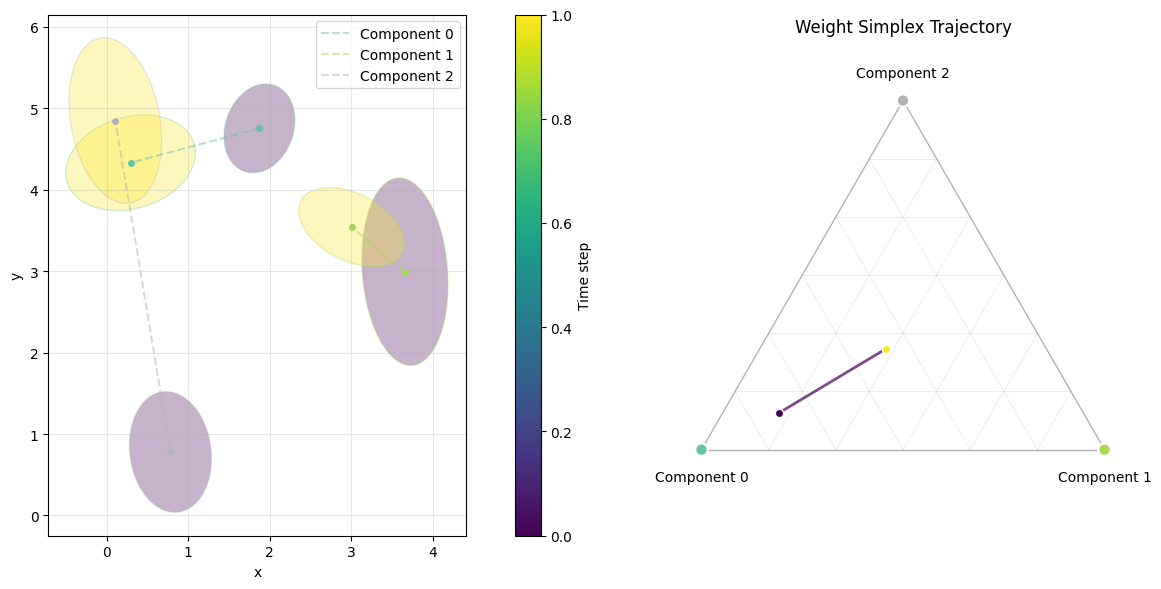

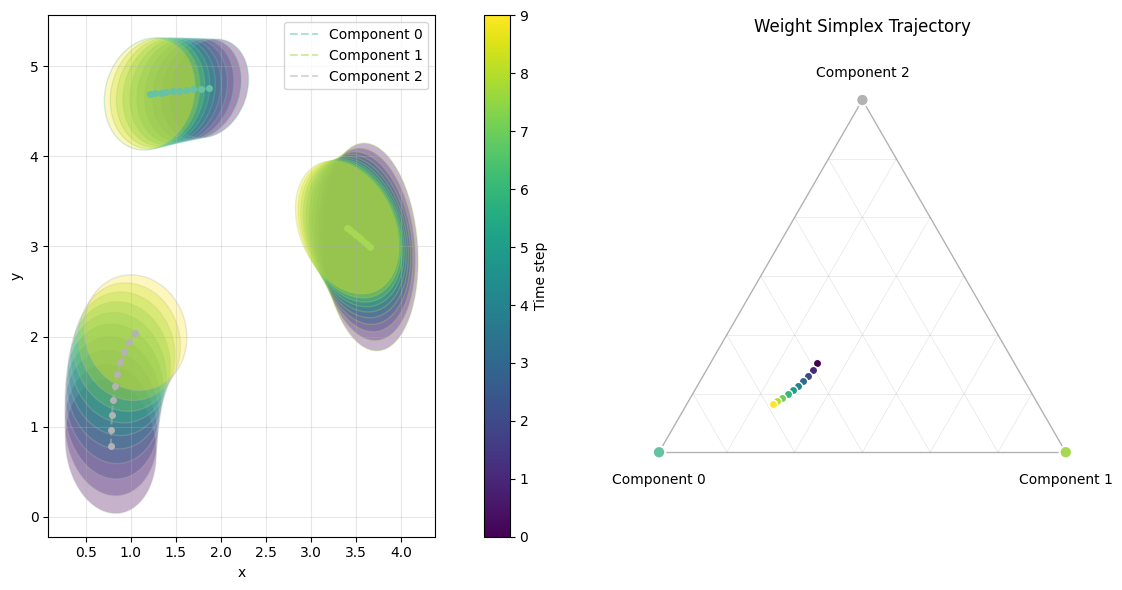

In [201]:
plot_gmm_trajectory(true_means, true_covs, true_weights)
plot_gmm_trajectory(ot_means, ot_covs, ot_weights)

(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

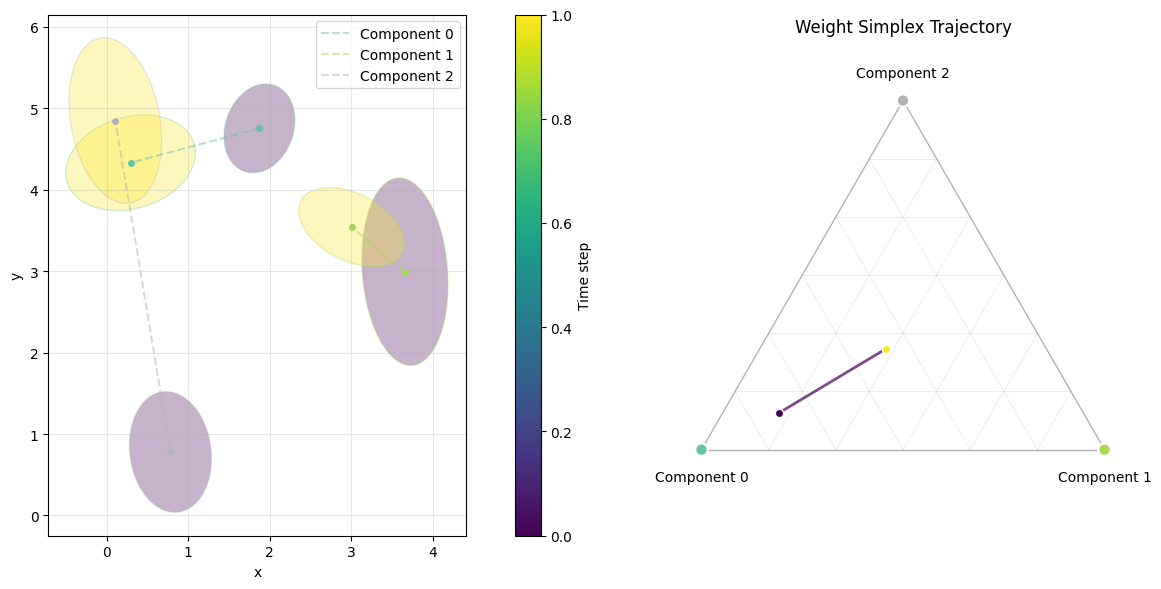

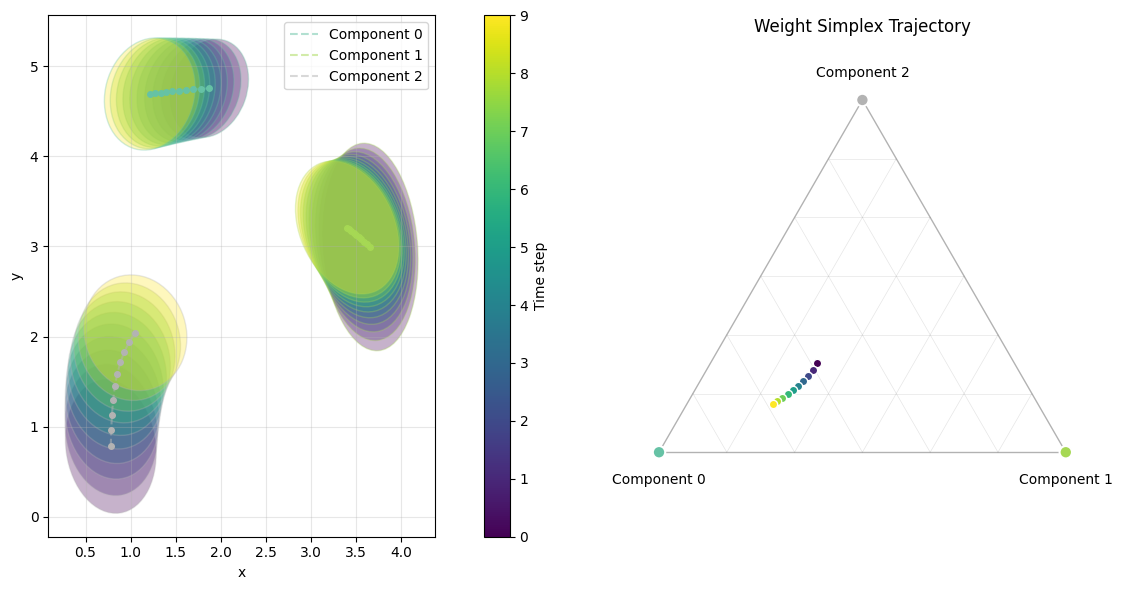

In [191]:
plot_gmm_trajectory(true_means, true_covs, true_weights)
plot_gmm_trajectory(ot_means, ot_covs, ot_weights)

In [8]:
from gmm_utils import fit_gmm_batch

resample_means, resample_covs, resample_weights = fit_gmm_batch(resample.cpu().numpy(), ot_means, ot_covs, ot_weights)



Fit GMM for mixture 0
Fit GMM for mixture 1
Fit GMM for mixture 2
Fit GMM for mixture 3
Fit GMM for mixture 4
Fit GMM for mixture 5
Fit GMM for mixture 6
Fit GMM for mixture 7
Fit GMM for mixture 8
Fit GMM for mixture 9


In [65]:
gmm_s['mean']

tensor([[1.8727, 4.7536],
        [3.6600, 2.9933],
        [0.7801, 0.7800]])

In [105]:
ot_means

array([[[1.87270057, 4.75357151],
        [3.65996981, 2.99329233],
        [0.78009319, 0.77997261]],

       [[0.72881663, 4.64101505],
        [3.36268997, 3.24173355],
        [0.72399145, 1.56506491]],

       [[1.69528329, 4.74059391],
        [3.62200975, 3.0250268 ],
        [0.78098011, 0.94656444]],

       [[1.5285691 , 4.72657919],
        [3.58421159, 3.05662632],
        [0.77720916, 1.07593572]],

       [[1.37583864, 4.71263266],
        [3.54722571, 3.08754611],
        [0.76945502, 1.18095732]],

       [[1.23794198, 4.69931746],
        [3.51145554, 3.11743522],
        [0.75839382, 1.26919115]],

       [[1.11312091, 4.68632984],
        [3.47799778, 3.1453898 ],
        [0.74909031, 1.34402704]],

       [[1.00112689, 4.67393255],
        [3.44681358, 3.17145872],
        [0.74149132, 1.40862048]],

       [[0.90146297, 4.66235399],
        [3.41765404, 3.19582915],
        [0.73492676, 1.46535146]],

       [[0.81315136, 4.6516161 ],
        [3.39048147, 3.2185478

In [62]:
ot_covs

array([[[[ 0.13346262,  0.01024   ],
         [ 0.01024   ,  0.12221061]],

        [[ 0.12702782,  0.00296451],
         [ 0.00296451,  0.20790718]],

        [[ 0.13358484,  0.01574102],
         [ 0.01574101,  0.0958079 ]]],


       [[[ 0.12677422,  0.00709585],
         [ 0.00709585,  0.1284827 ]],

        [[ 0.11291589, -0.00400841],
         [-0.00400841,  0.26378635]],

        [[ 0.11482665,  0.00810099],
         [ 0.00810099,  0.10960798]]],


       [[[ 0.1320449 ,  0.00940142],
         [ 0.00940142,  0.12446778]],

        [[ 0.11911203, -0.00078014],
         [-0.00078014,  0.24591532]],

        [[ 0.12201316,  0.01103396],
         [ 0.01103397,  0.10429344]]],


       [[[ 0.13277689,  0.00982482],
         [ 0.00982483,  0.12335932]],

        [[ 0.12195066,  0.00073669],
         [ 0.00073669,  0.23581502]],

        [[ 0.12552005,  0.01247283],
         [ 0.01247283,  0.10167197]]],


       [[[ 0.13305448,  0.00999168],
         [ 0.00999167,  0.12289862]],

    

In [88]:
ot_means

array([[[1.859366  , 4.7530146 ],
        [3.6411428 , 3.0007787 ],
        [0.77690613, 0.803084  ]],

       [[1.8712422 , 4.753514  ],
        [3.6578808 , 2.9941235 ],
        [0.7797393 , 0.7825389 ]],

       [[1.8697819 , 4.753456  ],
        [3.655796  , 2.9949522 ],
        [0.7793862 , 0.78509927]],

       [[1.8683193 , 4.753398  ],
        [3.6537158 , 2.9957793 ],
        [0.77903396, 0.7876536 ]],

       [[1.8668548 , 4.753335  ],
        [3.6516402 , 2.996605  ],
        [0.77868253, 0.7902021 ]],

       [[1.865388  , 4.753272  ],
        [3.649569  , 2.9974284 ],
        [0.77833194, 0.7927446 ]],

       [[1.8639191 , 4.753209  ],
        [3.6475024 , 2.99825   ],
        [0.7779821 , 0.7952811 ]],

       [[1.8624483 , 4.753146  ],
        [3.64544   , 2.9990702 ],
        [0.77763313, 0.79781175]],

       [[1.8609753 , 4.753083  ],
        [3.6433825 , 2.9998884 ],
        [0.777285  , 0.8003365 ]],

       [[1.859366  , 4.7530146 ],
        [3.6411428 , 3.0007787

(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

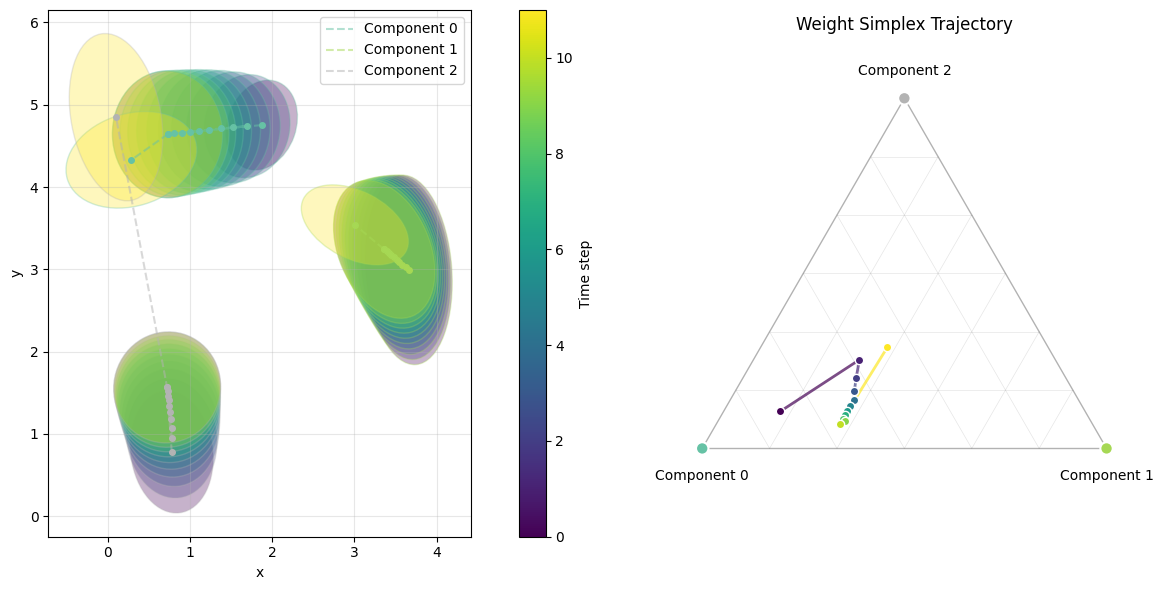

In [106]:
plot_gmm_trajectory(ot_means, ot_covs, ot_weights)

In [46]:
ot_means

array([[[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]],

       [[0.2405437, 4.4688478],
        [2.3825812, 3.599724 ],
        [0.4314266, 3.311168 ]]], dtype=float32)

(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

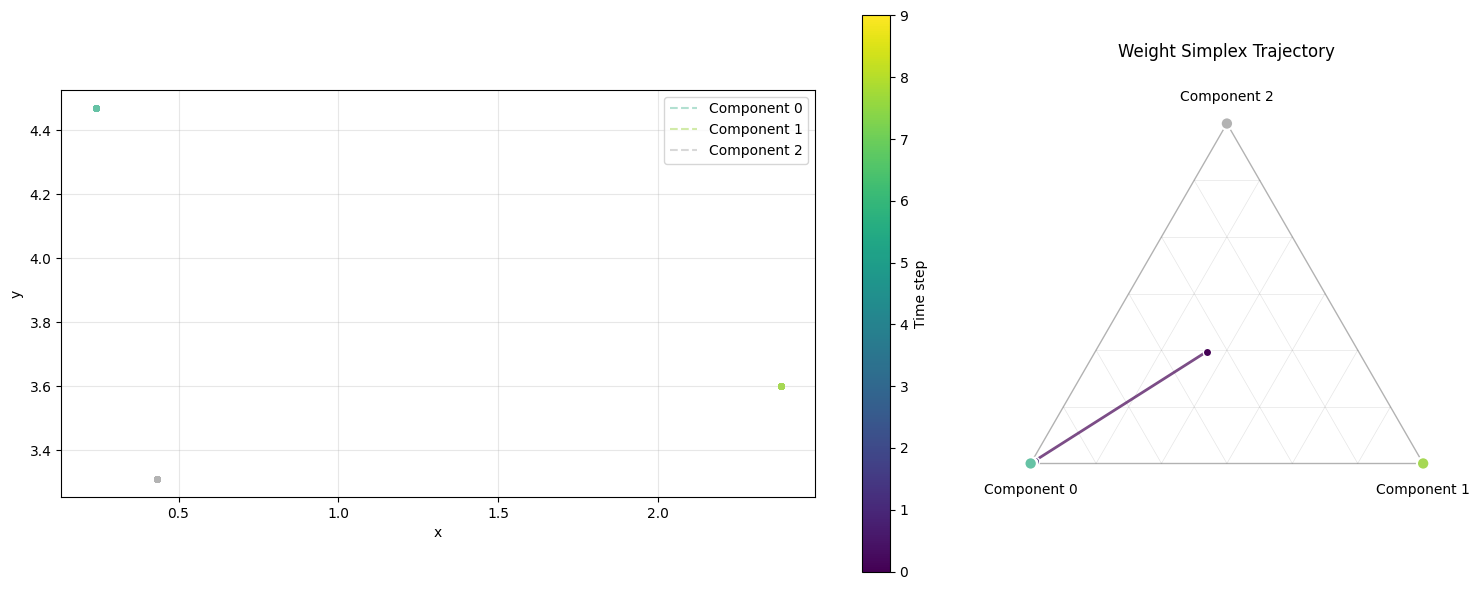

In [45]:
# from gmm_utils import plot_gmm_trajectory

plot_gmm_trajectory(ot_means, ot_covs, ot_weights)
# plot_gmm_trajectory(resample_means, resample_covs, resample_weights)